In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score as acc
from mlxtend.feature_selection import SequentialFeatureSelector as sfs
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
import math
from sklearn import model_selection
import os
import torch
from torch import nn
torch.manual_seed(3)
torch.cuda.manual_seed_all(3)

In [2]:
# Defining modle metrics
from sklearn.metrics import r2_score
def R2(y_true, y_pred):
    return round(r2_score(y_true, y_pred),3)
from sklearn.metrics import mean_squared_log_error
def MSLE(y_true, y_pred):
    return mean_squared_log_error(y_true, y_pred)
from sklearn.metrics import explained_variance_score
def EX_VAR(y_true, y_pred):
    return explained_variance_score(y_true, y_pred)
from sklearn.metrics import mean_absolute_error
def MAE(y_true, y_pred):
    return round(mean_absolute_error(y_true, y_pred),3)
from sklearn.metrics import mean_squared_error
def RMSE(y_true, y_pred):
    return round(mean_squared_error(y_true, y_pred,squared=True),3)

In [3]:
#Reading the data and droping a useless column and droping all rows with Nan values
#Scenario V-Modified.xlsx
DataSet = pd.read_excel( 'Dataset.xlsx').drop(columns=['name','DOI','content (%)', 'concrete elastic modulus(GPa)',
                                                          'Ductility index(deltap/deltay)','steel fiber type' ]).dropna()
# Making one hot encoding of a column
#data = pd.get_dummies(data=DataSet, columns=['steel fiber type'])
#data = data.drop(columns = ['Soil Type_Fissured'])
#data = data[data['Soil Type_Intact']>0]
# adding a new column with name Kfold, later we will use it 
data = DataSet.copy()

# scaling
scaler = MinMaxScaler()
scaler.fit(data)
#data = pd.DataFrame(scaler.transform(data.values), index=data.index, columns=data.columns)

data['kfold'] = -1
print(data.columns)
print(len(data))
data.head(5)

Index(['fiber aspect ratio(mm/mm)', 'fiber density(g/cm3)',
       'volume fraction(%)', 'reinforcement ratio(%)', 'beam width(mm)',
       'beam height(mm)', 'beam length(mm)', 'shear span-depth ratio',
       'fiber tensile strength(MPa)', 'Ductility index(deltau/deltay)',
       'Max Load', 'Deltap', 'kfold'],
      dtype='object')
127


,fiber aspect ratio(mm/mm),fiber density(g/cm3),volume fraction(%),reinforcement ratio(%),beam width(mm),beam height(mm),beam length(mm),shear span-depth ratio,fiber tensile strength(MPa),Ductility index(deltau/deltay),Max Load,Deltap,kfold
0,0.0,0.0,0.0,0.94,150,220,2500,5.0,0,10.34,62.6,94.53,-1
1,0.0,0.0,0.0,1.50,150,220,2500,5.0,0,6.06,97.9,73.03,-1
2,65.0,7.9,2.0,0.94,150,220,2500,5.0,2788,4.40,87.3,28.41,-1
3,65.0,7.9,2.0,1.50,150,220,2500,5.0,2788,4.04,124.1,20.30,-1
4,97.5,7.9,2.0,0.94,150,220,2500,5.0,2500,4.39,93.3,30.51,-1


In [4]:
#Random shuffling the data 
df = data.sample(frac= 1, random_state=20).reset_index(drop=True)

#Adding numbers for each fold of data to the Kfold column 
kf = model_selection.KFold(n_splits=5)
for fold, (trn_, val_) in enumerate(kf.split(X=df)):
    df.loc[val_, 'kfold'] = fold

# check the Kfold column, now we can select a scpecific chunk of data with using Kfold column
df.head(3)

,fiber aspect ratio(mm/mm),fiber density(g/cm3),volume fraction(%),reinforcement ratio(%),beam width(mm),beam height(mm),beam length(mm),shear span-depth ratio,fiber tensile strength(MPa),Ductility index(deltau/deltay),Max Load,Deltap,kfold
0,43.75,7.8,1.5,1.05,100,100,1000,6.0,1200,11.20,11.04,19.09,0
1,0.00,0.0,0.0,0.94,150,220,2500,5.0,0,10.34,62.60,94.53,0
2,82.50,7.5,1.5,1.58,200,300,3300,4.8,2500,4.50,243.30,19.40,0


In [5]:
df.columns

Index(['fiber aspect ratio(mm/mm)', 'fiber density(g/cm3)',
       'volume fraction(%)', 'reinforcement ratio(%)', 'beam width(mm)',
       'beam height(mm)', 'beam length(mm)', 'shear span-depth ratio',
       'fiber tensile strength(MPa)', 'Ductility index(deltau/deltay)',
       'Max Load', 'Deltap', 'kfold'],
      dtype='object')

In [6]:
def chained_model_gbm(data):
    n_estimators = 5000
    learning_rate = 0.01
    min_samples_leaf = 1
    min_samples_split = 2
    max_depth = 1
    result = []
    
    #change the range for hacing various k-folds 
    
    for i in range (4):
        
        print ('////////////   fold  {}  ////////////'.format(i))
        
        n_estimators = 3000
        learning_rate = 0.001
        min_samples_leaf = 6
        min_samples_split = 4
        max_depth = 6
        
        # ******* model I *****************************************
        test_fold = i
        x_all = df.drop(columns= ['Max Load','Ductility index(deltau/deltay)','Deltap'])
        x_train = df[df['kfold']!= test_fold].drop(columns= ['Max Load','Ductility index(deltau/deltay)','Deltap'])
        y_train = df[df['kfold']!= test_fold]['Max Load']
        x_test = df[df['kfold']== test_fold].drop(columns= ['Max Load','Ductility index(deltau/deltay)','Deltap'])
        y_test = df[df['kfold']== test_fold]['Max Load']
        
        # training the first GBM with data
        GB_1 = GradientBoostingRegressor(n_estimators=n_estimators,learning_rate=learning_rate
                                ,min_samples_leaf=min_samples_leaf ,min_samples_split=min_samples_split, max_depth=max_depth)
        GB_1.fit(x_train,y_train)
        pred_train_max_load = GB_1.predict(x_train)
        pred_test_max_load = GB_1.predict(x_test)
        
        print ('*****test*****')
        print ('R2 Max load on {} fold = '.format(i), R2(y_test,pred_test_max_load.flatten()))
        print ('MAE Max load on {} fold = '.format(i), MAE(y_test,pred_test_max_load.flatten()))
        print ('RMSE Max load on {} fold = '.format(i), RMSE(y_test,pred_test_max_load.flatten()))
        
        print('****train******')
        print ('R2 Max load on {} fold = '.format(i), R2(y_train,pred_train_max_load.flatten()))
        print ('MAE Max load on {} fold = '.format(i), MAE(y_train,pred_train_max_load.flatten()))
        print ('RMSE Max load on {} fold = '.format(i), RMSE(y_train,pred_train_max_load.flatten()))
        
        # Concatinating max load prediction with the data
        df['max_load_pred'] = GB_1.predict(x_all)
        
        # ******* model II *****************************************
        n_estimators = 3000
        learning_rate = 0.001
        min_samples_leaf = 6
        min_samples_split = 4
        max_depth = 6
        
        x_all = df.drop(columns= ['Max Load','Ductility index(deltau/deltay)','Deltap'])
        x_train = df[df['kfold']!= test_fold].drop(columns= ['Max Load','Ductility index(deltau/deltay)','Deltap'])
        y_train = df[df['kfold']!= test_fold]['Deltap']
        x_test = df[df['kfold']== test_fold].drop(columns= ['Max Load','Ductility index(deltau/deltay)','Deltap'])
        y_test = df[df['kfold']== test_fold]['Deltap']
        
        # training the first GBM with data
        GB_2 = GradientBoostingRegressor(n_estimators=n_estimators,learning_rate=learning_rate
                                ,min_samples_leaf=min_samples_leaf ,min_samples_split=min_samples_split, max_depth=max_depth)
        GB_2.fit(x_train,y_train)
        pred_train_Deltap = GB_2.predict(x_train)
        pred_test_Deltap = GB_2.predict(x_test)
        
        print ('*****test*****')
        print ('R2 Deltap on {} fold = '.format(i), R2(y_test,pred_test_Deltap.flatten()))
        print ('MAE Deltap on {} fold = '.format(i), MAE(y_test,pred_test_Deltap.flatten()))
        print ('RMSE Deltap on {} fold = '.format(i), RMSE(y_test,pred_test_Deltap.flatten()))
        
        print('****train******')
        print ('R2 Deltap on {} fold = '.format(i), R2(y_train,pred_train_Deltap.flatten()))
        print ('MAE Deltap on {} fold = '.format(i), MAE(y_train,pred_train_Deltap.flatten()))
        print ('RMSE Deltap on {} fold = '.format(i), RMSE(y_train,pred_train_Deltap.flatten()))
        
        # Concatinating Deltap prediction with the data
        df['Deltap_pred'] = GB_2.predict(x_all)
        
        # ******* model III *****************************************
        n_estimators = 3000
        learning_rate = 0.001
        min_samples_leaf = 6
        min_samples_split = 4
        max_depth = 6
        
        x_all = df.drop(columns= ['Max Load','Ductility index(deltau/deltay)','Deltap'])
        x_train = df[df['kfold']!= test_fold].drop(columns= ['Max Load','Ductility index(deltau/deltay)','Deltap'])
        y_train = df[df['kfold']!= test_fold]['Ductility index(deltau/deltay)']
        x_test = df[df['kfold']== test_fold].drop(columns= ['Max Load','Ductility index(deltau/deltay)','Deltap'])
        y_test = df[df['kfold']== test_fold]['Ductility index(deltau/deltay)']
        
        # training the first GBM with data
        GB_3 = GradientBoostingRegressor(n_estimators=n_estimators,learning_rate=learning_rate
                                ,min_samples_leaf=min_samples_leaf ,min_samples_split=min_samples_split, max_depth=max_depth)
        GB_3.fit(x_train,y_train)
        pred_train_Ductility_index = GB_3.predict(x_train)
        pred_test_Ductility_index = GB_3.predict(x_test)
        
        print ('*****test*****')
        print ('R2 Ductility index on {} fold = '.format(i), R2(y_test,pred_test_Ductility_index.flatten()))
        print ('MAE Ductility index on {} fold = '.format(i), MAE(y_test,pred_test_Ductility_index.flatten()))
        print ('RMSE Ductility index on {} fold = '.format(i), RMSE(y_test,pred_test_Ductility_index.flatten()))
        
        print('****train******')
        print ('R2 Ductility index on {} fold = '.format(i), R2(y_train,pred_train_Ductility_index.flatten()))
        print ('MAE Ductility index on {} fold = '.format(i), MAE(y_train,pred_train_Ductility_index.flatten()))
        print ('RMSE Ductility index on {} fold = '.format(i), RMSE(y_train,pred_train_Ductility_index.flatten()))
        
        # Concatinating max load prediction with the data
        df['Ductility_index_pred'] = GB_3.predict(x_all)
        
        
        
result = chained_model_gbm (df)

////////////   fold  0  ////////////
*****test*****
R2 Max load on 0 fold =  0.909
MAE Max load on 0 fold =  17.044
RMSE Max load on 0 fold =  470.333
****train******
R2 Max load on 0 fold =  0.943
MAE Max load on 0 fold =  10.644
RMSE Max load on 0 fold =  214.682
*****test*****
R2 Deltap on 0 fold =  0.153
MAE Deltap on 0 fold =  10.811
RMSE Deltap on 0 fold =  414.726
****train******
R2 Deltap on 0 fold =  0.878
MAE Deltap on 0 fold =  3.8
RMSE Deltap on 0 fold =  45.057
*****test*****
R2 Ductility index on 0 fold =  -0.036
MAE Ductility index on 0 fold =  2.58
RMSE Ductility index on 0 fold =  28.32
****train******
R2 Ductility index on 0 fold =  0.829
MAE Ductility index on 0 fold =  0.849
RMSE Ductility index on 0 fold =  1.69
////////////   fold  1  ////////////
*****test*****
R2 Max load on 1 fold =  0.932
MAE Max load on 1 fold =  13.115
RMSE Max load on 1 fold =  362.991
****train******
R2 Max load on 1 fold =  0.982
MAE Max load on 1 fold =  6.237
RMSE Max load on 1 fold =  

In [19]:
df.head()

,fiber aspect ratio(mm/mm),fiber density(g/cm3),volume fraction(%),reinforcement ratio(%),beam width(mm),beam height(mm),beam length(mm),shear span-depth ratio,fiber tensile strength(MPa),Ductility index(deltau/deltay),Max Load,Deltap,kfold,max_load_pred,Deltap_pred,Ductility_index_pred
0,43.75,7.8,1.5,1.05,100,100,1000,6.00,1200,11.20,11.04,19.09,0,24.785313,22.146616,14.393812
1,0.00,0.0,0.0,0.94,150,220,2500,5.00,0,10.34,62.60,94.53,0,63.409739,64.763242,8.582806
2,82.50,7.5,1.5,1.58,200,300,3300,4.80,2500,4.50,243.30,19.40,0,233.075010,18.467050,4.667590
3,43.75,7.8,0.0,2.10,100,100,1000,6.00,1200,6.00,16.41,14.09,0,24.785313,14.958839,6.646069
4,0.00,7.8,0.0,0.28,150,150,1200,2.45,0,14.00,30.00,55.00,0,30.094735,53.686400,14.393812


In [8]:
dft = df[df['kfold']== 0]

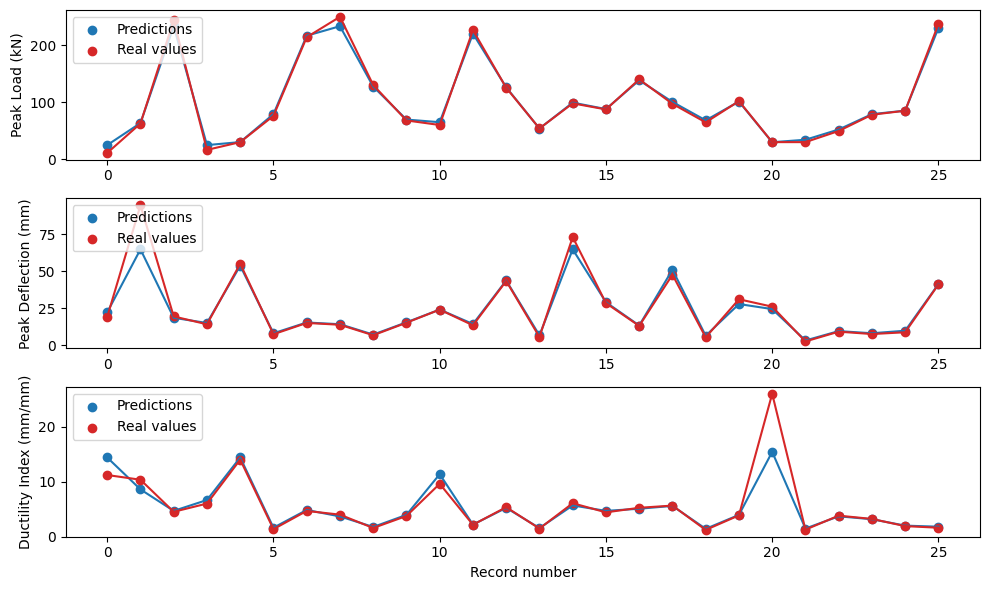

In [9]:
fig, axes = plt.subplots(3, 1, figsize=(10, 6))
x = [i for i in range(len(dft))]

# Plot the first figure in the first subplot
axes[2].scatter(x, dft['Ductility_index_pred'], color = 'tab:blue', label='Predictions')
axes[2].scatter(x, dft['Ductility index(deltau/deltay)'], color='tab:red', label='Real values')
axes[2].plot(x, dft['Ductility_index_pred'], color = 'tab:blue')
axes[2].plot(x, dft['Ductility index(deltau/deltay)'], color='tab:red')
axes[2].set_xlabel('Record number')
axes[2].set_ylabel('Ductility Index (mm/mm)')
axes[2].legend(loc='upper left')

# Plot the second figure in the second subplot
axes[0].scatter(x, dft['max_load_pred'], color = 'tab:blue', label='Predictions')
axes[0].scatter(x, dft['Max Load'], color='tab:red', label='Real values')
axes[0].plot(x, dft['max_load_pred'], color = 'tab:blue')
axes[0].plot(x, dft['Max Load'], color='tab:red')
#axes[0].set_xlabel('Record number')
axes[0].set_ylabel('Peak Load (kN)')
axes[0].legend(loc='upper left')

# Plot the third figure in the third subplot
axes[1].scatter(x, dft['Deltap_pred'], color = 'tab:blue', label='Predictions')
axes[1].scatter(x, dft['Deltap'], color='tab:red', label='Real values')
axes[1].plot(x, dft['Deltap_pred'], color = 'tab:blue')
axes[1].plot(x, dft['Deltap'], color='tab:red')
axes[1].legend(loc='upper left')
#axes[1].set_xlabel('Record number')
axes[1].set_ylabel('Peak Deflection (mm)')

# Adjust the spacing between subplots
plt.tight_layout()
#plt.savefig('absolute_values.pdf', dpi=1200)
# Display the figures
plt.show()

(0.0, 27.0)

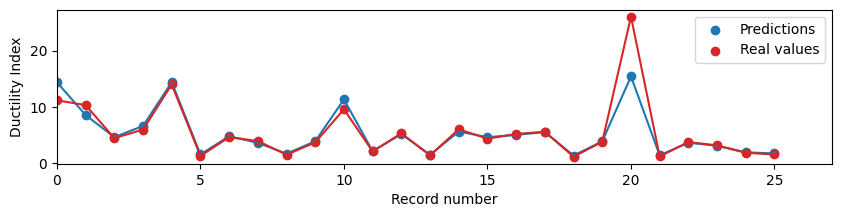

In [30]:
x = [i for i in range(len(dft))]
fig = plt.figure(figsize =(10,2))
plt.scatter(x, dft['Ductility_index_pred'], color = 'tab:blue', label='Predictions')
plt.scatter(x, dft['Ductility index(deltau/deltay)'], color='tab:red', label='Real values')
plt.plot(x, dft['Ductility_index_pred'], color = 'tab:blue')
plt.plot(x, dft['Ductility index(deltau/deltay)'], color='tab:red')
plt.xlabel('Record number')
plt.ylabel('Ductility Index')
plt.legend()
plt.xlim(0,27)

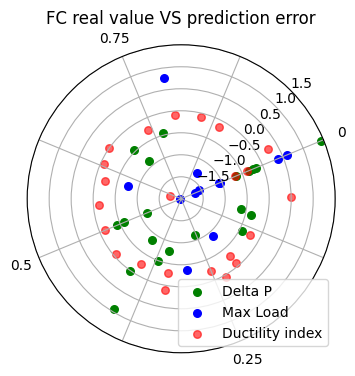

In [10]:
# Compute areas and colors
#N = 150
#area = 200 * r**2 , s=area
#colors = theta

range_error = 1
fig = plt.figure(figsize =(4,4))
ax = fig.add_subplot(projection='polar')

ax.set_rlim(-2,1.5)
#c = ax.scatter(angel, data['Error'], c=data['Error'], cmap='hsv', alpha=0.75)

y_test = df[df['kfold']== 0]['Deltap']
y_pred = df[df['kfold']== 0]['Deltap_pred']
angel = (1 - y_test/range_error ) * 2 * np.pi
c = ax.scatter(angel, (y_test.to_numpy() - y_pred.to_numpy()), alpha=1, label= 'Delta P', color ='green',
               s=30,marker = 'o')

y_test = df[df['kfold']== 0]['Max Load']
y_pred = df[df['kfold']== 0]['max_load_pred']
angel = (1 - y_test/range_error ) * 2 * np.pi
c = ax.scatter(angel, (y_test.to_numpy() - y_pred.to_numpy()), alpha=1, color = 'blue',
               label= 'Max Load', s=30,marker = 'o')



y_test = df[df['kfold']== 0]['Ductility index(deltau/deltay)']
y_pred = df[df['kfold']== 0]['Ductility_index_pred']
angel = (1 - y_test/range_error ) * 2 * np.pi
c = ax.scatter(angel, (y_test.to_numpy() - y_pred.to_numpy()), alpha=0.6, color = 'red', label= 'Ductility index',
               s=30,marker = 'o')


# Set the offset for the theta (angular) axis
ax.set_theta_offset(np.pi / 8)  # Adjust the starting point of the angular axis if needed

# Define custom angular ticks (in radians) and corresponding labels
custom_ticks = np.linspace(0, 2 * np.pi, 8, endpoint=False)  # Define the angular positions for ticks
custom_labels = ['0', '', '0.75', '', '0.5', '', '0.25', '']  # Define labels for ticks

# Set the custom angular ticks and labels
ax.set_xticks(custom_ticks)
ax.set_xticklabels(custom_labels)

ax.legend()
plt.title("FC real value VS prediction error")
plt.savefig('fig.png', dpi = 1000)